In [1]:
# Common imports
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
#% matplotlib inline


## The third Environment definition
Implement a time-varying out-flow for the simple gas environment

In the previous Envs, the out_flow was modeled as constant; we want a somewhat more realistic out_flow behaviour.
The out_flow:
- should be semi-sinusoidal (much out_flow in the morning, less over the day, much again in the evening)
- should be slightly random (not the same for every episode)
- can be initialized as a numpy array in the reset() method of the environment

In [2]:
# Where to save the figures
Project_Root = "."
Figures_Path = os.path.join(Project_Root, "figures")
os.makedirs(Figures_Path, exist_ok=True)

def save_fig(fig_id, crl_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(Figures_Path, fig_id + crl_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)  #transparent=True
    return


### A semi-sinusoidal function

Saving figure  


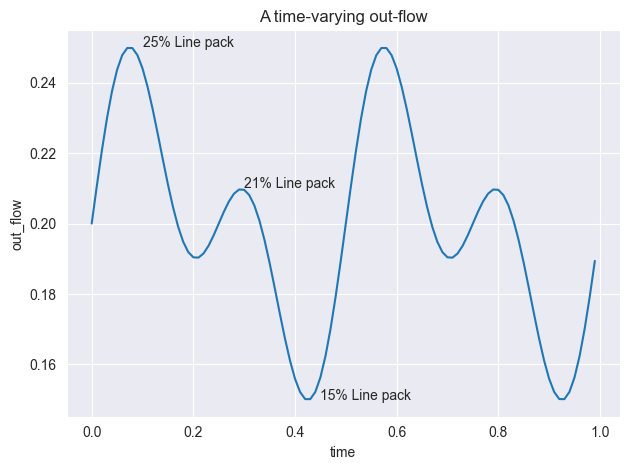

In [43]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.arange(0, 1, 0.01)
fq= 2

y1 = 0.029 * np.sin(2*np.pi*fq*x) + 0.2
y2 = 0.028 * np.sin(2*np.pi*2*fq*x )

y = y1 + y2

#fig, axs = plt.subplots(2)
#axs[0].plot(x, y1)
#axs[1].plot(x, y2)

plt.plot(x, y)
#plt.axis([0, 1, 0, 1])
plt.xlabel('time')
plt.ylabel('out_flow')
plt.title('A time-varying out-flow')
#plt.annotate('45% Line pack', xy=(.1, .45), xytext=(.2, .45),
#             arrowprops=dict(arrowstyle = "->"),
#             )
plt.text(.1, .25, r'25% Line pack')
plt.text(.45, .15, r'15% Line pack')
plt.text(.3, .21, r'21% Line pack')
#plt.axhline(y=0.25)
#plt.axhline(y=0.21)
#plt.axhline(y=0.15)
save_fig(" ", "OutFlow_function")
plt.show()

### Test the out-flow function

In [4]:
def out_flow_function (x):
    fq= 2
    y1 = 0.029 * np.sin(2*np.pi*fq*x) + 0.2
    y2 = 0.028 * np.sin(2*np.pi*2*fq*x )
    y = y1 + y2
    return y


In [5]:
# out_flow is issued according
out_flow = out_flow_function(0)
out_flow


0.2

### Test the environment

In [6]:
from third_gas_environment import SimpleGasEnvironment


In [7]:
def make_env():
    env = SimpleGasEnvironment(in_flow=0.4)
    from stable_baselines3.common.env_checker import check_env

    # It will check your custom environment and output additional warnings if needed
    check_env(env)
    return env

In [8]:
env = make_env()

C:\Users\outafraout\Anaconda3\envs\pythonProject\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [9]:
obs = env.reset()

In [10]:
obs

array([0.45134112, 0.551193  , 0.30238885], dtype=float32)

In [11]:
action = 2  # UP
obs, reward, done, info = env.step(action)
obs

array([0.45132202, 0.751193  , 0.23245211], dtype=float32)

In [12]:
action = 0  # DOWN
obs, reward, done, info = env.step(action)
obs

array([0.45120227, 0.551193  , 0.22543344], dtype=float32)

## Policy evaluation utils


In [36]:
def evaluate_policy(policy, env, crl_id):
    linepacks = []
    valve_positions = []
    actions = []
    rewards = []
    outflow = []

    n_steps = 500
    obs = env.reset()

    for i in range(n_steps):
        act = policy(obs)
        obs, reward, done, info = env.step(act)
        linepacks.append(obs[0])
        valve_positions.append(env.valve_position)
        actions.append(act)
        rewards.append(reward)
        outflow.append(obs[2])

        if done:
            print("Game over")
            break

    plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1) # 2 rows, 2 cols, 1st fig
    plt.plot(linepacks)
    plt.title("Linepacks")
    plt.subplot(2, 2, 2) # 2 rows, 2 cols, 2nd fig
    plt.plot(valve_positions)
    plt.title("Valve positions")
    plt.subplot(2, 2, 3) # 2 rows, 2 cols, 3rd fig
    plt.plot(actions)
    plt.title("Actions")
    plt.subplot(2, 2, 4) # 2 rows, 2 cols, 4th fig
    plt.title("Rewards")
    plt.plot(rewards)
    print("Achieved rewards:", np.sum(rewards))
    save_fig("EvaluatePolicy", crl_id)
    plt.show()

    #plt.figure(figsize=(6,4))
    #plt.plot(outflow)
    #plt.title('A time-varying out-flow')
    #plt.text(.1, .25, r'25% Line pack')
    #plt.text(.45, .15, r'15% Line pack')
    #plt.text(.3, .21, r'21% Line pack')
    #save_fig(" ", "OutFlow")
    #plt.show()


In [37]:
def visualize_policy_lp(policy):
    line_pack_ranges = np.linspace(0, 1, 1000)
    actions = np.array([policy( np.array([lp, 0.5])) for lp in line_pack_ranges])
    plt.plot(line_pack_ranges, actions)
    plt.title("Policy")

In [38]:
#import numpy as np
import seaborn as sns
#import matplotlib.pylab as plt

def visualize_policy(policy, crl_id):
    line_pack_ranges = np.linspace(0, 1, 10)
    valve_positions = np.linspace(0, 1, 10)

    actions = np.array([[policy( np.array([lp, vp])) for vp in valve_positions] for lp in line_pack_ranges])
    ax = sns.heatmap(actions, linewidth=0.5)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1, 2])
    colorbar.set_ticklabels([f'({SimpleGasEnvironment.DOWN}) DOWN',
                             f'({SimpleGasEnvironment.NOTHING}) NOTHING',
                             f'({SimpleGasEnvironment.UP}) UP'])

    ax.set(xlabel="Valve position",
           xticklabels=np.round(line_pack_ranges, 2),
           ylabel="Linepack",
           yticklabels=np.round(valve_positions, 2))
    plt.title("Policy")
    save_fig("Policy", crl_id)
    plt.show()


## Fixed policy control

In [39]:
def bang_bang_control(obs):
    if obs[0] < 0.5: # obs[0] contains the lineback
        return SimpleGasEnvironment.UP
    else:
        return SimpleGasEnvironment.DOWN


Saving figure Policy


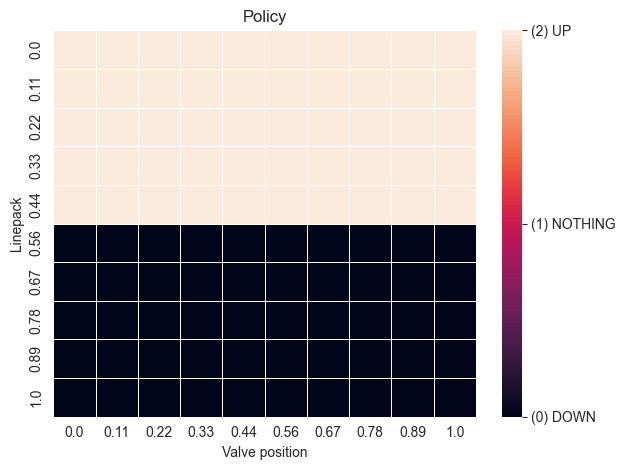

In [40]:
visualize_policy(bang_bang_control, "BangBangControl")

Achieved rewards: 2449.0234370704684
Saving figure EvaluatePolicy


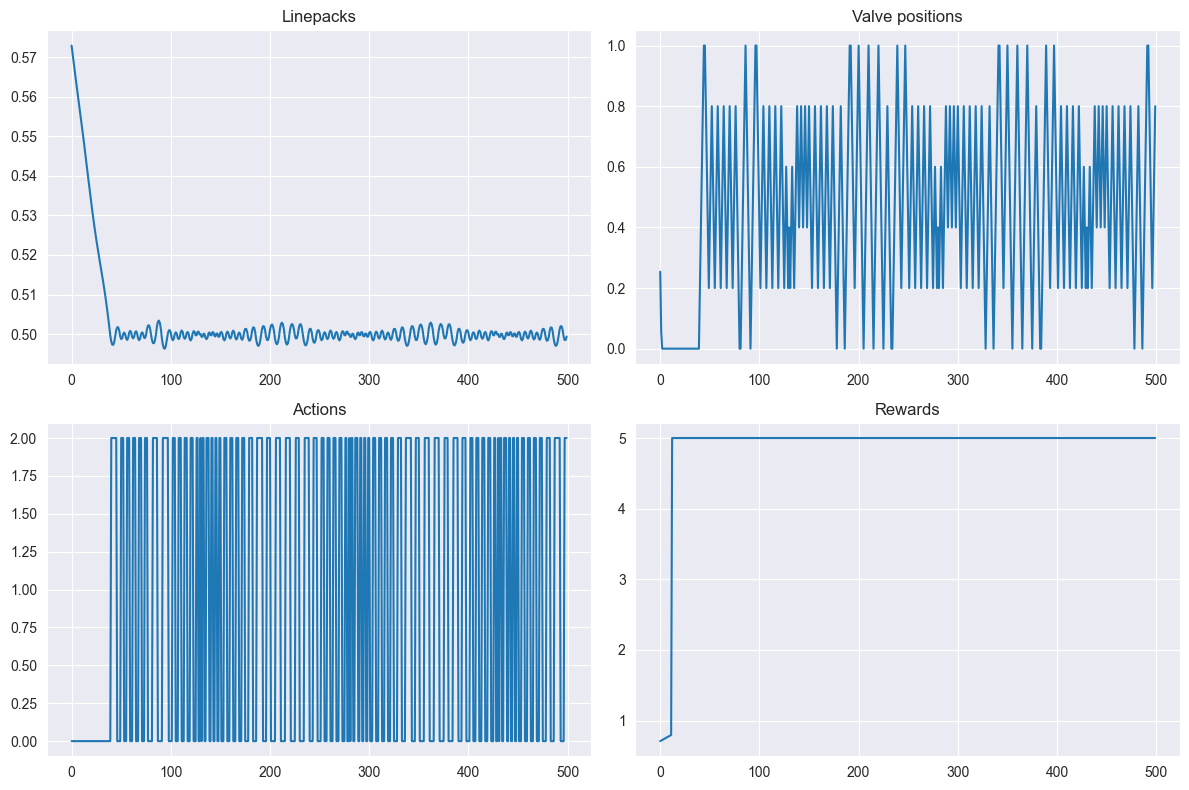

In [42]:
obs = env.reset()
evaluate_policy(bang_bang_control, env, "BangBangControl_Env3")

## Training an RL-Agent

In [ ]:
def model_wrapper(model):
    return lambda obs : model.predict(obs, deterministic=True)[0]